#  Skin Cancer Classification using Deep Learning  
###  Models Used: Custom CNN | ResNet50V2 | EfficientNetB2 | EfficientNetB3 | EfficientNetB4  
**Course:** ENGG 683 – Advanced Machine Learning Applications  
**Project Title:** Deep Learning Approaches for Melanoma Detection  
**Group Number:** 15  
**University:** University of Calgary  
**Submission Date:** 4th April 2025  
**Google Colab Notebook:** [Open in Colab](https://colab.research.google.com/drive/10XUhDIofvWu0nTNowdLhkHIPzL3AGQQj)

---

###  Group Members

| Student Name        | Student ID |
|---------------------|------------|
| Om Vipulbhai Patel  | 30243246   |
| Sanket Patel        | 30246586   |
| Sadia Khan          | 30090271   |
| Ramanpreet Kaur     | 30270427   |

---

###  Project Overview  
In this project, a complete deep learning workflow was designed to detect skin cancer from dermoscopic images. Five different CNN models were trained and assessed for their effectiveness in distinguishing between benign and malignant lesions.

---

###  Models & Image Sizes  
| Model               | Input Image Size |
|---------------------|------------------|
| **Custom CNN**      | 224 × 224         |
| **ResNet50V2**      | 224 × 224         |
|  **EfficientNetB2**  | 260 × 260         |
| **EfficientNetB3**  | 300 × 300         |
|  **EfficientNetB4**  | 380 × 380         |

All pretrained models used ImageNet weights and were fine-tuned on our melanoma dataset. Image resizing was performed based on each model’s input size requirement.

---

###  Dataset Summary  
- Source: Kaggle (Melanoma Skin Cancer Dataset)  
- Total Images: **10,605**  
  - Training: 9605  
  - Validation/Test: 1000  
- Classes:  
  - **0 = Benign**, **1 = Malignant**  
- Preprocessing Steps:
  - Rescaling pixel values using `rescale=1./255`  
  - Image resizing based on the model  
  - Applied class weights to handle class imbalance

---

###  Training Setup  
- **Batch Size:** 32  
- **Epochs:** 10  
- **Optimizer:** Adam with learning rate decay  
- **Loss Function:** Binary Crossentropy  
- **Callbacks:** EarlyStopping, ModelCheckpoint  
- **Validation Split:** 10% from training data

---

###  Evaluation Metrics  
The models were evaluated using the following metrics:

- Accuracy  
- Precision  
- Recall  
- F1-Score  
- Confusion Matrix  
- ROC AUC Curve  
- Threshold Optimization

---

###  Misclassification Analysis  
- **EfficientNetB2** misclassified **332 samples** out of 1000 test images.  
- These images were visualized with predicted vs. actual labels.  
- This analysis helped identify common failure cases and borderline classifications.

---

> This notebook delivers a complete deep learning-based approach for melanoma detection — covering image preprocessing, model training, evaluation, and error analysis — using both custom and state-of-the-art convolutional architectures.


# Environment Setup and Dependency Installation

In [1]:
'''
    If you face any issues, when you will try to run this code on google colab.
    regarding exceed use of memory, than please try to run using VSCODE.

    Ideal Python version for this code is: 3.9.6 or later.
'''
!pip3 install kaggle
!pip3 install cv2

!pip3 install opencv-python numpy matplotlib tensorflow scikit-learn
!pip3 install pandas
!pip3 install seaborn
# !pip3 install numpy==1.24.3
!pip3 install 'numpy>=1.25.0'

!kaggle --version

!which kaggle

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2
Kaggle API 1.7.4.2
/usr/local/bin/kaggle


# Importing Required Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50V2, VGG19, DenseNet169, EfficientNetB2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

# Kaggle API Authentication and Dataset Download

In [3]:
import os
import zipfile

# Step 1: Set up Kaggle API key (securely stores in ~/.kaggle)
kaggle_dir = os.path.expanduser("~/.kaggle")
kaggle_json = """{
  "username": "ovpatel",
  "key": "1f8296429204f5e64164e62f0b8a0b28"
}"""

os.makedirs(kaggle_dir, exist_ok=True)

with open(os.path.join(kaggle_dir, "kaggle.json"), "w") as f:
    f.write(kaggle_json)

# Set permissions (won't affect much on Windows, but still included)
try:
    os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)
except PermissionError:
    print(" Permission warning ignored on Windows.")

print(f" Kaggle API Key stored in: {kaggle_dir}")

# Step 2: Download the dataset using kaggle CLI
dataset_name = "hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images"
download_path = kaggle_dir  # Save zip to the same kaggle folder

download_cmd = f'kaggle datasets download -d {dataset_name} -p "{download_path}" --force'
print(" Downloading dataset...")
os.system(download_cmd)

# Step 3: Find downloaded .zip file
zip_files = [f for f in os.listdir(download_path) if f.endswith(".zip")]
if not zip_files:
    print(" No zip file found in the download path.")
    exit()

dataset_zip_path = os.path.join(download_path, zip_files[0])
print(f" Found ZIP: {dataset_zip_path}")

# Step 4: Extract ZIP
extract_path = os.path.join(download_path, "melanoma_cancer_dataset")
os.makedirs(extract_path, exist_ok=True)

print(" Extracting...")
with zipfile.ZipFile(dataset_zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction Complete!")

# Step 5: Show dataset structure (works on Windows)
print(" Folder structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")

 Kaggle API Key stored in: /root/.kaggle
 Found ZIP: /root/.kaggle/melanoma-skin-cancer-dataset-of-10000-images.zip
 Extracting...
Extraction Complete!
 Folder structure:
melanoma_cancer_dataset/
    melanoma_cancer_dataset/
        test/
            malignant/
                melanoma_10243.jpg
                melanoma_10398.jpg
                melanoma_10518.jpg
                melanoma_10554.jpg
                melanoma_10129.jpg
            benign/
                melanoma_10098.jpg
                melanoma_9631.jpg
                melanoma_9915.jpg
                melanoma_10077.jpg
                melanoma_10053.jpg
        train/
            malignant/
                melanoma_5884.jpg
                melanoma_6747.jpg
                melanoma_9392.jpg
                melanoma_7791.jpg
                melanoma_8910.jpg
            benign/
                melanoma_3872.jpg
                melanoma_4363.jpg
                melanoma_4806.jpg
                melanoma_2896.jpg
      

# Label Definition and Image Configuration


In [4]:

LABELS = ['malignant', 'benign']
IMG_SIZE = 224

# Loading the Dataset from Directory

In [5]:


# Function to load images properly
def load_data(directory, img_size=(IMG_SIZE, IMG_SIZE), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

# Load datasets
train_dir = kaggle_dir + "/melanoma_cancer_dataset/melanoma_cancer_dataset/train"
test_dir = kaggle_dir + "/melanoma_cancer_dataset/melanoma_cancer_dataset/test"

train_data = load_data(train_dir)
test_data = load_data(test_dir)

# Verify dataset
print(f" Train data loaded: {train_data}")
print(f" Test data loaded: {test_data}")





Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
 Train data loaded: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
 Test data loaded: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# Resnet50V2 Model - IMG Size = 224


Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 249s 619ms/step - accuracy: 0.8094 - loss: 0.4286 - val_accuracy: 0.8940 - val_loss: 0.2661 - learning_rate: 1.0000e-04
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 155s 515ms/step - accuracy: 0.8930 - loss: 0.2598 - val_accuracy: 0.9070 - val_loss: 0.2962 - learning_rate: 1.0000e-04
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 156s 519ms/step - accuracy: 0.9125 - loss: 0.2226 - val_accuracy: 0.9100 - val_loss: 0.2134 - learning_rate: 1.0000e-04
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 156s 517ms/step - accuracy: 0.9151 - loss: 0.2076 - val_accuracy: 0.9080 - val_loss: 0.2798 - learning_rate: 1.0000e-04
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 201s 515ms/step - accuracy: 0.9210 - loss: 0.2055 - val_accuracy: 

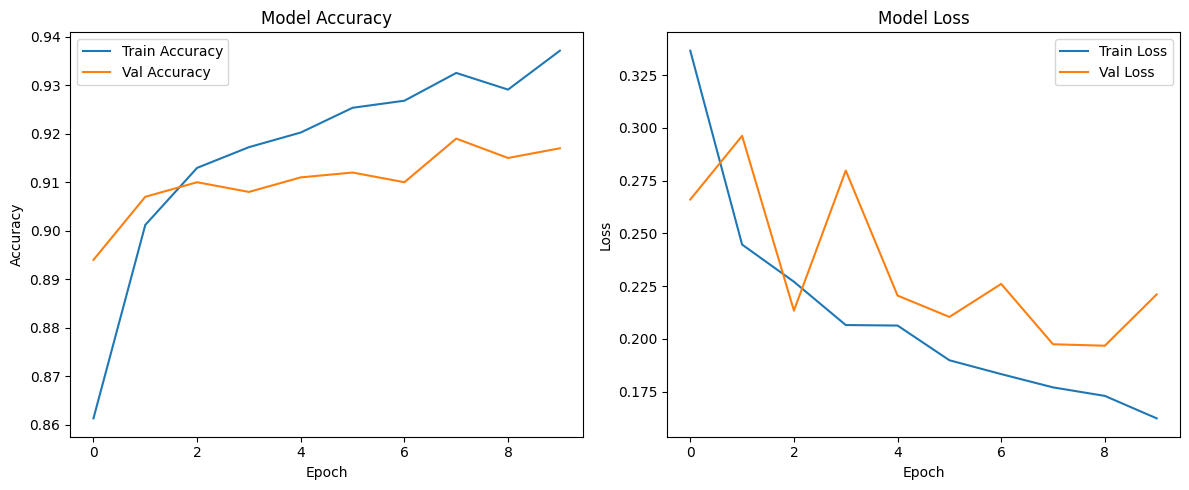

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step


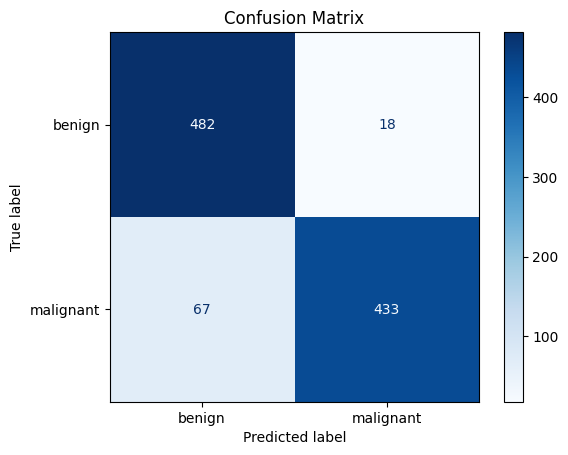


Classification Report:

              precision    recall  f1-score   support

      benign       0.88      0.96      0.92       500
   malignant       0.96      0.87      0.91       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.91      1000
weighted avg       0.92      0.92      0.91      1000



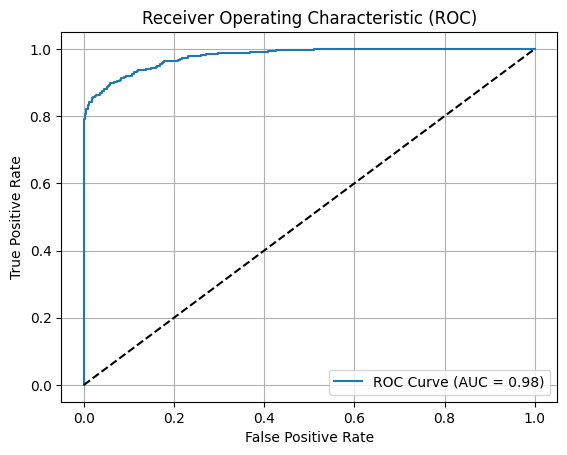

Number of Misclassified Samples: 85


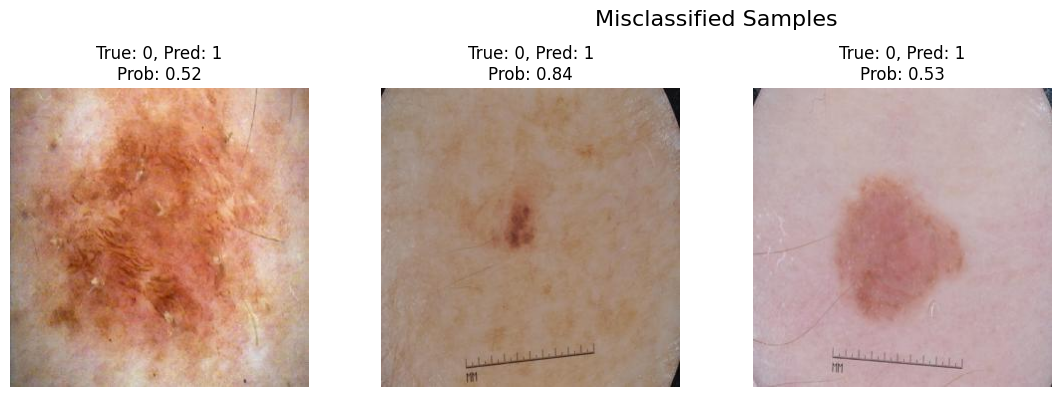

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Print class index mapping
print("Class Indices:", test_generator.class_indices)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Model Architecture
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True  # Fine-tune all layers (adjust to unfreeze specific layers if needed)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights
    )

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Get filenames from test_generator
filenames = test_generator.filenames

# Identify misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"Number of Misclassified Samples: {len(misclassified_indices)}")

# Plot a few misclassified images
num_images_to_show = min(3, len(misclassified_indices))  # Show up to 12 images
plt.figure(figsize=(15, 10))

for i, idx in enumerate(misclassified_indices[:num_images_to_show]):
    img_path = test_generator.filepaths[idx]
    img = plt.imread(img_path)

    true_label = y_true[idx]
    predicted_label = y_pred[idx]
    predicted_prob = y_pred_probs[idx]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {predicted_label}\nProb: {predicted_prob:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16, y=1.02)
plt.show()





# EfficientNetB2 Model: IMG SIZE = 260

Physical devices cannot be modified after being initialized
Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5108 - loss: 0.1033
Epoch 1: val_loss improved from inf to 0.04094, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 283s 404ms/step - accuracy: 0.5108 - loss: 0.1033 - val_accuracy: 0.5730 - val_loss: 0.0409 - learning_rate: 1.0000e-04
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.5127 - loss: 0.0801
Epoch 2: val_loss did not improve from 0.04094
601/601 ━━━━━━━━━━━━━━━━━━━━ 193s 321ms/step - accuracy: 0.5127 - loss: 0.0801 - val_accuracy: 0.6550 - val_loss: 0.0417 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.5099 - loss: 0.0718
Epoch 3: val_loss did not improve from 0.04094
601/601 ━━━━━━━━━━━━━━━━━━━━ 191s 318ms/step - accuracy: 0.5099 - loss: 0.0718 - val_accuracy: 0.6030 - val_loss: 0.0423 - learning_rate: 1.0000e-04
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5086 - loss: 0.0663
Epoch 4: val_loss did not improve from 0.04094
601/601 ━━━━━━━━━━━━━━━━━━━━ 189s 314ms/step - accuracy: 0.5086 - loss: 0.0663 - val_accuracy: 0.5000 - val_loss: 0.0432 - learning_rate: 1.0000e-04

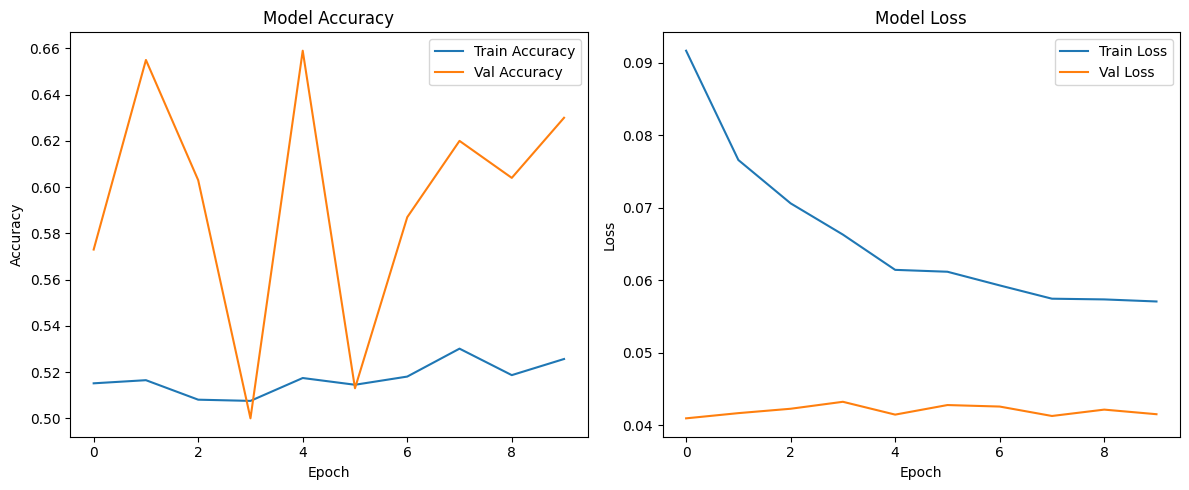

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step
Optimal Threshold: 0.52


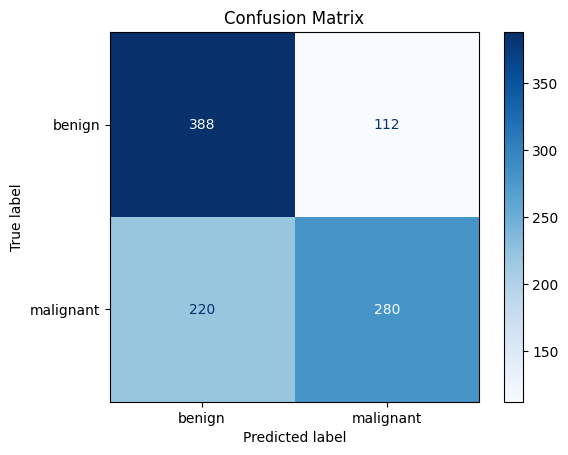


Classification Report:

              precision    recall  f1-score   support

      benign       0.64      0.78      0.70       500
   malignant       0.71      0.56      0.63       500

    accuracy                           0.67      1000
   macro avg       0.68      0.67      0.66      1000
weighted avg       0.68      0.67      0.66      1000



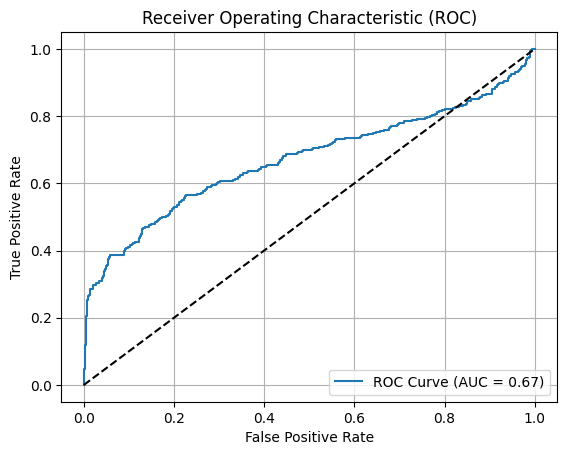

Total Misclassified Samples: 332


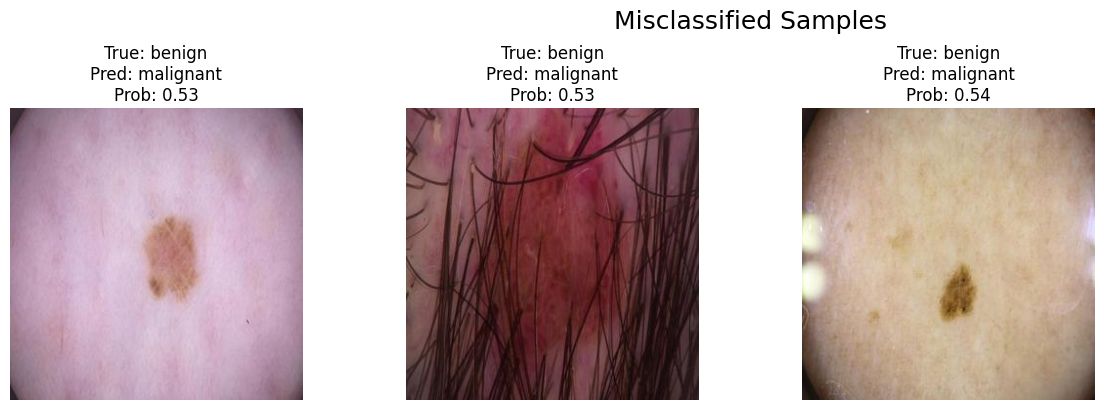

In [ ]:
# Skin Cancer Classification with EfficientNetB2 and Optimized Settings

# Set constants
IMG_SIZE = 260
BATCH_SIZE = 16

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB2 with partial layer freezing
base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



# Misclassified Samples

# Get file paths and class labels
filepaths = test_generator.filepaths
class_labels = list(test_generator.class_indices.keys())

# Identify misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]

print(f"Total Misclassified Samples: {len(misclassified_indices)}")

# Plot a few misclassified samples
num_to_display = min(3, len(misclassified_indices))
plt.figure(figsize=(16, 10))

for i, idx in enumerate(misclassified_indices[:num_to_display]):
    img = plt.imread(filepaths[idx])
    true_class = class_labels[y_true[idx]]
    predicted_class = class_labels[y_pred[idx]]
    confidence = y_pred_probs[idx]

    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {predicted_class}\nProb: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=18, y=1.02)
plt.show()



# EfficientNetB3 Model - Image Size 300

Physical devices cannot be modified after being initialized
Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.5124 - loss: 0.1083
Epoch 1: val_loss improved from inf to 0.04423, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 332s 478ms/step - accuracy: 0.5124 - loss: 0.1083 - val_accuracy: 0.5200 - val_loss: 0.0442 - learning_rate: 1.0000e-04
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5161 - loss: 0.0794
Epoch 2: val_loss did not improve from 0.04423
601/601 ━━━━━━━━━━━━━━━━━━━━ 258s 428ms/step - accuracy: 0.5161 - loss: 0.0794 - val_accuracy: 0.5000 - val_loss: 0.0444 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5114 - loss: 0.0746
Epoch 3: val_loss improved from 0.04423 to 0.04318, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 259s 431ms/step - accuracy: 0.5114 - loss: 0.0746 - val_accuracy: 0.4960 - val_loss: 0.0432 - learning_rate: 1.0000e-04
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5007 - loss: 0.0713
Epoch 4: val_loss improved from 0.04318 to 0.04095, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 259s 431ms/step - accuracy: 0.5007 - loss: 0.0713 - val_accuracy: 0.6290 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.5335 - loss: 0.0629
Epoch 5: val_loss did not improve from 0.04095
601/601 ━━━━━━━━━━━━━━━━━━━━ 261s 434ms/step - accuracy: 0.5335 - loss: 0.0629 - val_accuracy: 0.6750 - val_loss: 0.0419 - learning_rate: 1.0000e-04
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.5136 - loss: 0.0617
Epoch 6: val_loss improved from 0.04095 to 0.04093, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 257s 428ms/step - accuracy: 0.5136 - loss: 0.0617 - val_accuracy: 0.6790 - val_loss: 0.0409 - learning_rate: 1.0000e-04
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.5169 - loss: 0.0582
Epoch 7: val_loss did not improve from 0.04093
601/601 ━━━━━━━━━━━━━━━━━━━━ 255s 424ms/step - accuracy: 0.5169 - loss: 0.0582 - val_accuracy: 0.5490 - val_loss: 0.0423 - learning_rate: 1.0000e-04
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.5298 - loss: 0.0540
Epoch 8: val_loss did not improve from 0.04093
601/601 ━━━━━━━━━━━━━━━━━━━━ 261s 433ms/step - accuracy: 0.5298 - loss: 0.0540 - val_accuracy: 0.5290 - val_loss: 0.0416 - learning_rate: 5.0000e-05
Epoch 9/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5347 - loss: 0.0552
Epoch 9: val_loss did not improve from 0.04093
601/601 ━━━━━━━━━━━━━━━━━━━━ 258s 428ms/step - accuracy: 0.5347 - loss: 0.0552 - val_accuracy: 0.5080 - val_loss: 0.0416 - learning_rate: 5.0000e-05

601/601 ━━━━━━━━━━━━━━━━━━━━ 264s 439ms/step - accuracy: 0.5319 - loss: 0.0538 - val_accuracy: 0.7150 - val_loss: 0.0400 - learning_rate: 5.0000e-05
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.7557 - loss: 0.0400
Final Validation Accuracy: 71.50%


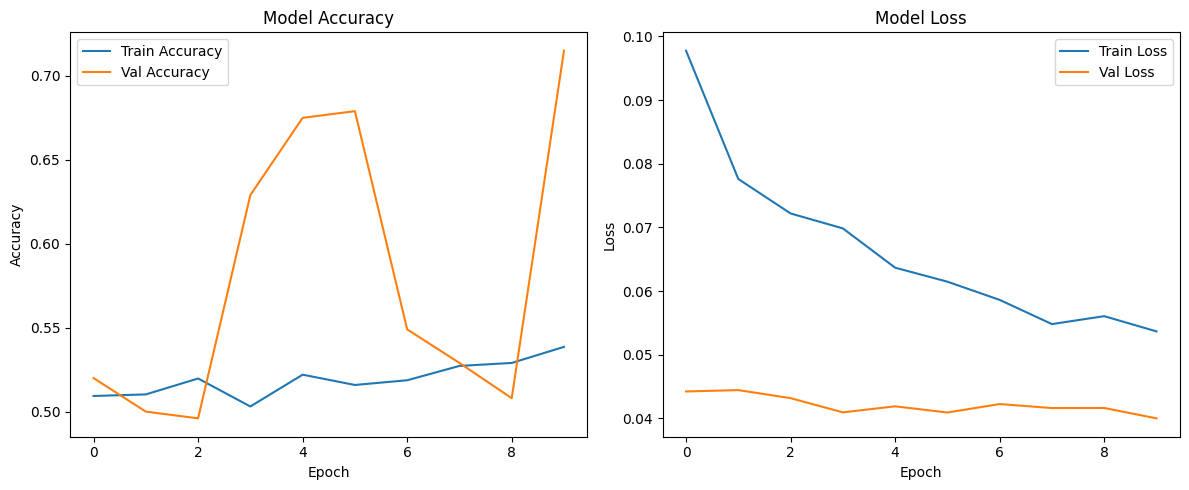

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step
Optimal Threshold: 0.49


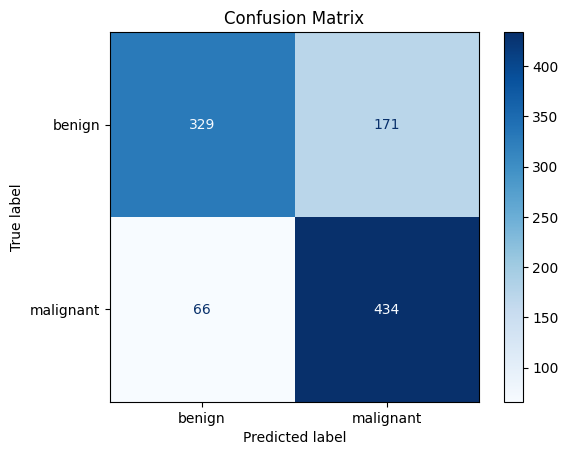


Classification Report:

              precision    recall  f1-score   support

      benign       0.83      0.66      0.74       500
   malignant       0.72      0.87      0.79       500

    accuracy                           0.76      1000
   macro avg       0.78      0.76      0.76      1000
weighted avg       0.78      0.76      0.76      1000



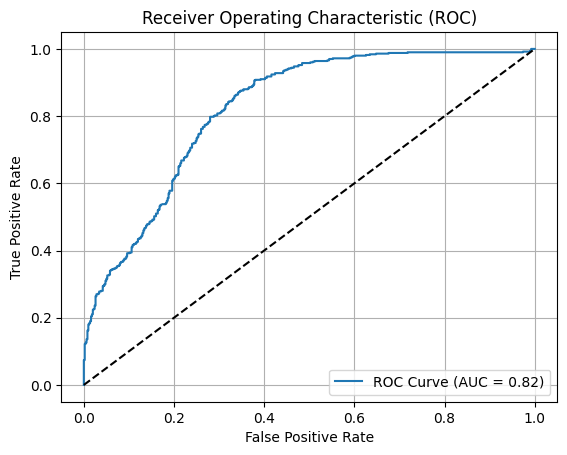

Total Misclassified Samples: 237


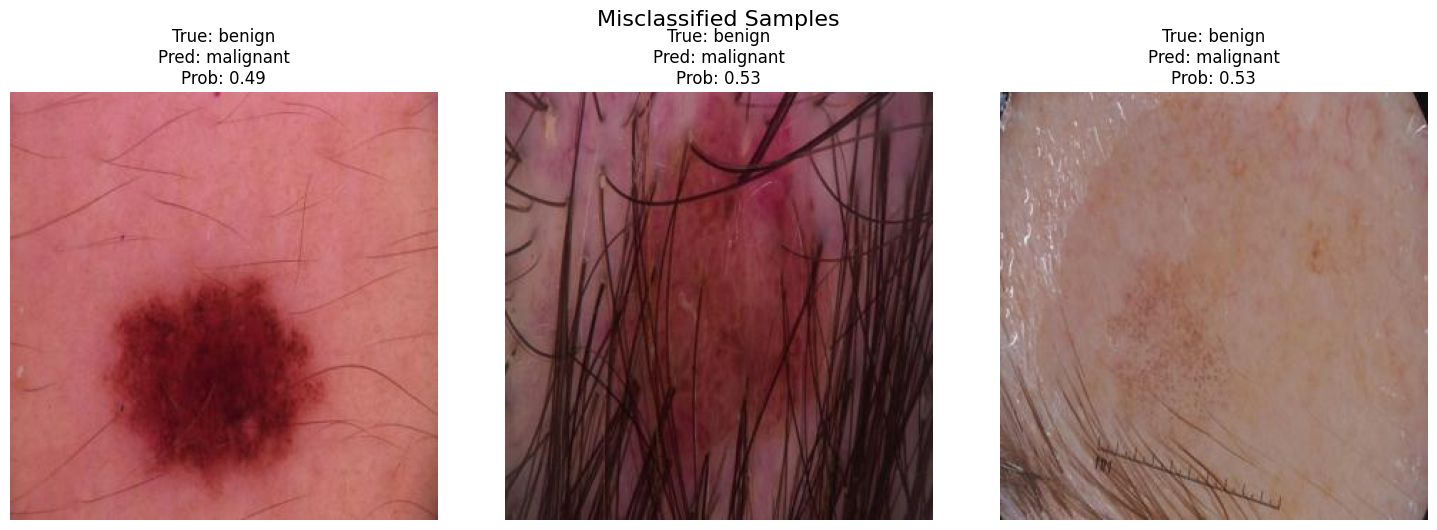

In [ ]:
# Skin Cancer Classification with EfficientNetB3 and Optimized Settings


from tensorflow.keras.applications import EfficientNetB3
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Set constants
IMG_SIZE = 300
BATCH_SIZE = 16

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB3 with partial layer freezing
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Misclassified Sample Display (3 samples)
filepaths = test_generator.filepaths
class_labels = list(test_generator.class_indices.keys())

# Find misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total Misclassified Samples: {len(misclassified_indices)}")

# Show up to 3 misclassified samples
num_to_display = min(3, len(misclassified_indices))

plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_to_display]):
    img = plt.imread(filepaths[idx])
    true_class = class_labels[y_true[idx]]
    predicted_class = class_labels[y_pred[idx]]
    confidence = y_pred_probs[idx]

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {predicted_class}\nProb: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16, y=1.05)
plt.show()


# EfficientNetB4 Model - Image Size 380

Physical devices cannot be modified after being initialized
Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.5089 - loss: 0.1191
Epoch 1: val_loss improved from inf to 0.06516, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 488s 717ms/step - accuracy: 0.5089 - loss: 0.1191 - val_accuracy: 0.5000 - val_loss: 0.0652 - learning_rate: 1.0000e-04
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.5083 - loss: 0.0913
Epoch 2: val_loss improved from 0.06516 to 0.05103, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 393s 653ms/step - accuracy: 0.5084 - loss: 0.0913 - val_accuracy: 0.5000 - val_loss: 0.0510 - learning_rate: 1.0000e-04
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.5218 - loss: 0.0782
Epoch 3: val_loss improved from 0.05103 to 0.04069, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 383s 636ms/step - accuracy: 0.5218 - loss: 0.0782 - val_accuracy: 0.6700 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.5251 - loss: 0.0732
Epoch 4: val_loss did not improve from 0.04069
601/601 ━━━━━━━━━━━━━━━━━━━━ 377s 626ms/step - accuracy: 0.5251 - loss: 0.0732 - val_accuracy: 0.5000 - val_loss: 0.0441 - learning_rate: 1.0000e-04
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.5253 - loss: 0.0676
Epoch 5: val_loss did not improve from 0.04069
601/601 ━━━━━━━━━━━━━━━━━━━━ 376s 626ms/step - accuracy: 0.5253 - loss: 0.0676 - val_accuracy: 0.5630 - val_loss: 0.0425 - learning_rate: 1.0000e-04
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5238 - loss: 0.0661
Epoch 6: val_loss improved from 0.04069 to 0.04067, saving model to best_model.h5


601/601 ━━━━━━━━━━━━━━━━━━━━ 375s 624ms/step - accuracy: 0.5238 - loss: 0.0661 - val_accuracy: 0.6770 - val_loss: 0.0407 - learning_rate: 1.0000e-04
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.5159 - loss: 0.0608
Epoch 7: val_loss did not improve from 0.04067
601/601 ━━━━━━━━━━━━━━━━━━━━ 381s 633ms/step - accuracy: 0.5159 - loss: 0.0608 - val_accuracy: 0.6670 - val_loss: 0.0407 - learning_rate: 5.0000e-05
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5237 - loss: 0.0586
Epoch 8: val_loss did not improve from 0.04067
601/601 ━━━━━━━━━━━━━━━━━━━━ 373s 621ms/step - accuracy: 0.5237 - loss: 0.0586 - val_accuracy: 0.6710 - val_loss: 0.0409 - learning_rate: 5.0000e-05
Epoch 9/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.5183 - loss: 0.0578
Epoch 9: val_loss did not improve from 0.04067
601/601 ━━━━━━━━━━━━━━━━━━━━ 389s 647ms/step - accuracy: 0.5183 - loss: 0.0578 - val_accuracy: 0.6010 - val_loss: 0.0419 - learning_rate: 5.0000e-05

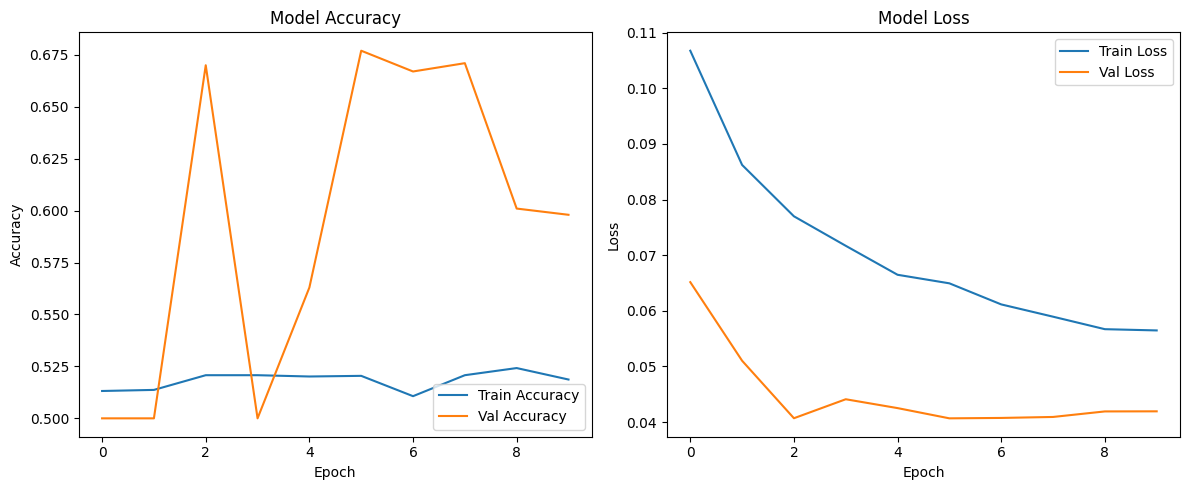

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 289ms/step
Optimal Threshold: 0.51


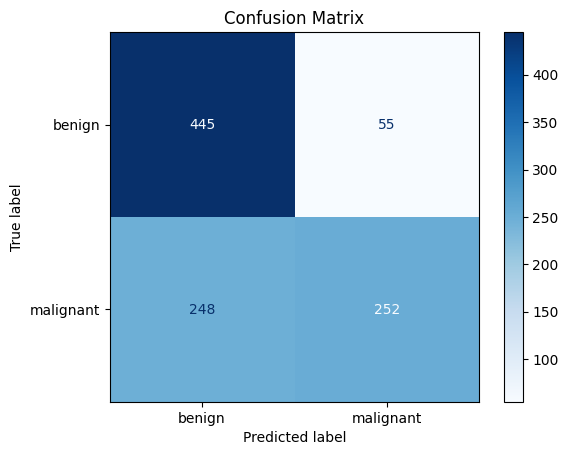


Classification Report:

              precision    recall  f1-score   support

      benign       0.64      0.89      0.75       500
   malignant       0.82      0.50      0.62       500

    accuracy                           0.70      1000
   macro avg       0.73      0.70      0.69      1000
weighted avg       0.73      0.70      0.69      1000



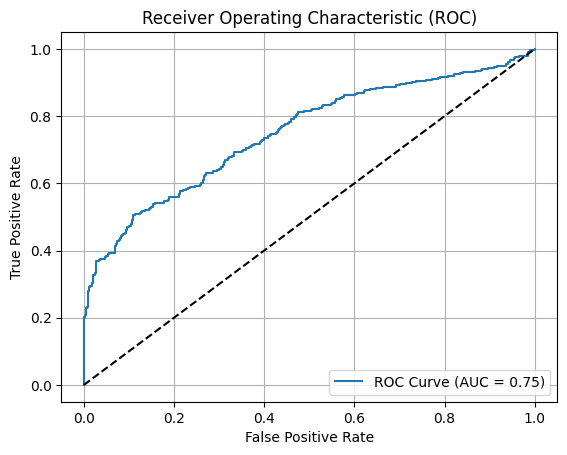

Total Misclassified Samples: 303


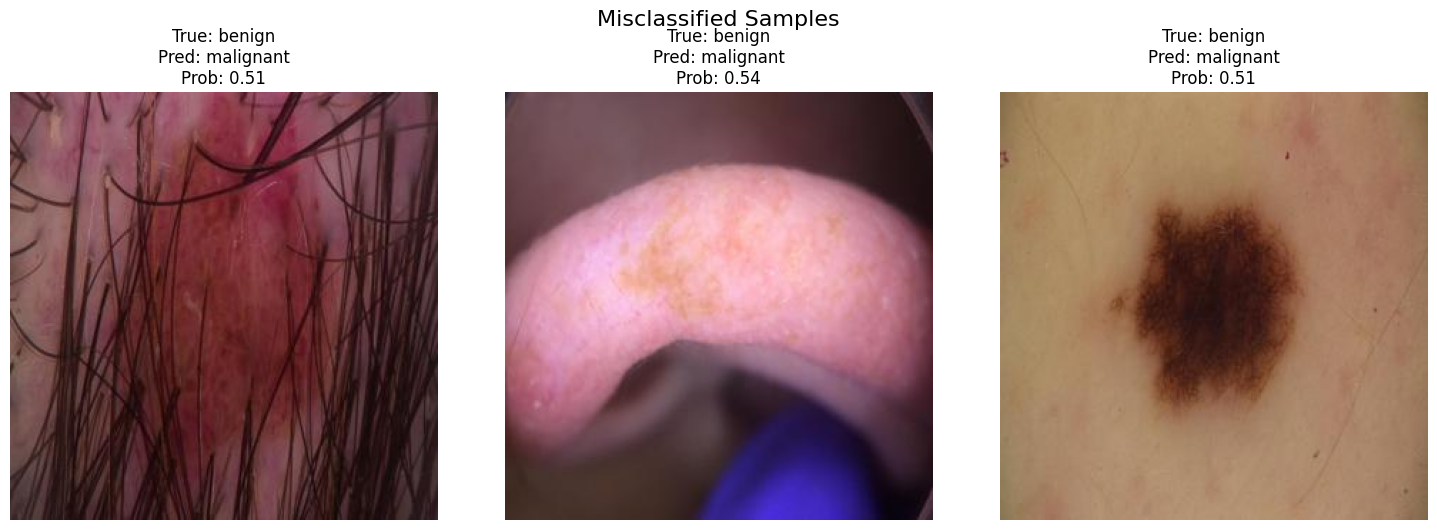

In [6]:
# Skin Cancer Classification with EfficientNetB2 and Optimized Settings

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB4
# from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay

# Set constants
IMG_SIZE = 380
BATCH_SIZE = 16

# Enable memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Advanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    shear_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss_val = -alpha * tf.pow(1 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# Model: EfficientNetB2 with partial layer freezing
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-20]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1)

# Train
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()

# Optimal threshold tuning
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_thresh:.2f}")

y_pred = (y_pred_probs > optimal_thresh).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# Misclassified Sample Display (3 samples)
filepaths = test_generator.filepaths
class_labels = list(test_generator.class_indices.keys())

# Find misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total Misclassified Samples: {len(misclassified_indices)}")

# Show up to 3 misclassified samples
num_to_display = min(3, len(misclassified_indices))

plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_to_display]):
    img = plt.imread(filepaths[idx])
    true_class = class_labels[y_true[idx]]
    predicted_class = class_labels[y_pred[idx]]
    confidence = y_pred_probs[idx]

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {predicted_class}\nProb: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16, y=1.05)
plt.show()


# CNN Model - IMG Size = 224

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Class Indices: {'benign': 0, 'malignant': 1}
Class Weights: {0: np.float64(0.9605), 1: np.float64(1.0428881650380022)}
Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 157s 494ms/step - accuracy: 0.7886 - loss: 1.1340 - val_accuracy: 0.5710 - val_loss: 1.6635 - learning_rate: 1.0000e-04
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 136s 451ms/step - accuracy: 0.8571 - loss: 0.5552 - val_accuracy: 0.8860 - val_loss: 0.3255 - learning_rate: 1.0000e-04
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 135s 448ms/step - accuracy: 0.8669 - loss: 0.4309 - val_accuracy: 0.8950 - val_loss: 0.2863 - learning_rate: 1.0000e-04
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 137s 454ms/step - accuracy: 0.8758 - loss: 0.4131 - val_accuracy: 0.9000 - val_loss: 0.2469 - learning_rate: 1.0000e-04
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 136s 452ms/step - accuracy: 0.8745 - loss: 0.3657 - val_accuracy: 0.8820 - val_loss: 0.2695 - learning_rate: 1.0000e-

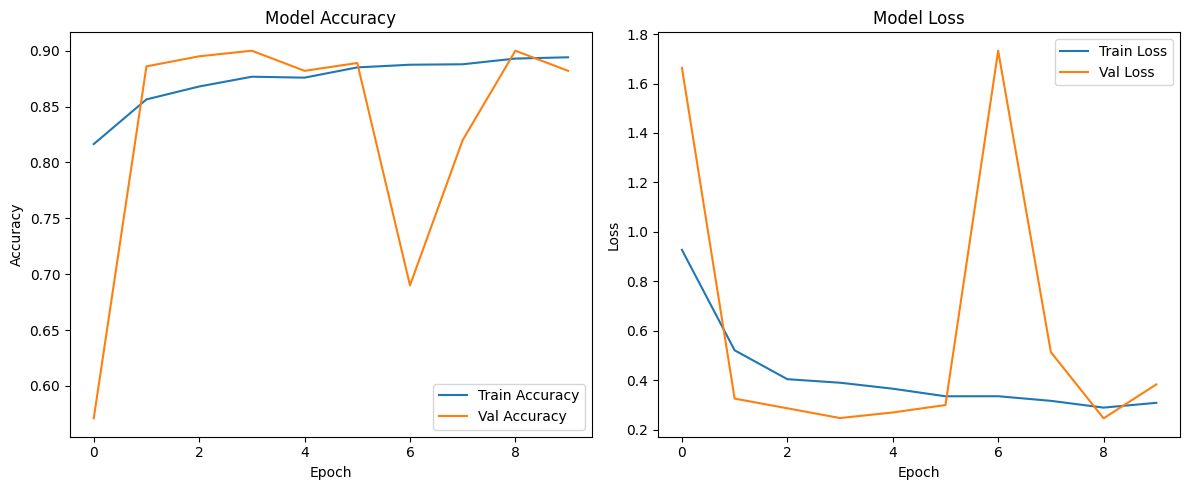

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


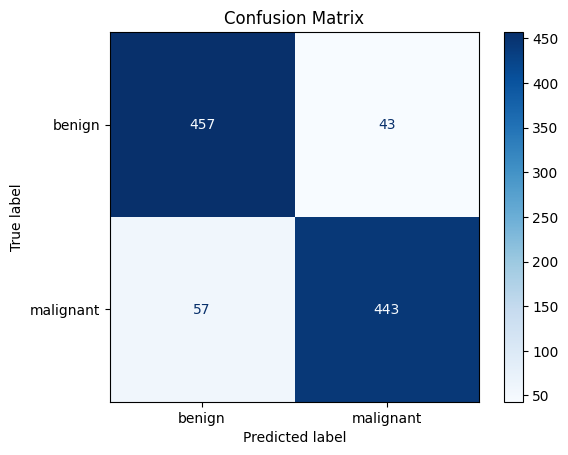


Classification Report:

              precision    recall  f1-score   support

      benign       0.89      0.91      0.90       500
   malignant       0.91      0.89      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



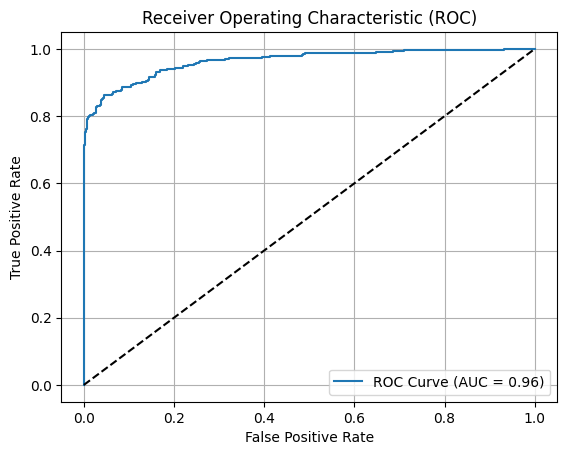

Total Misclassified Samples: 100


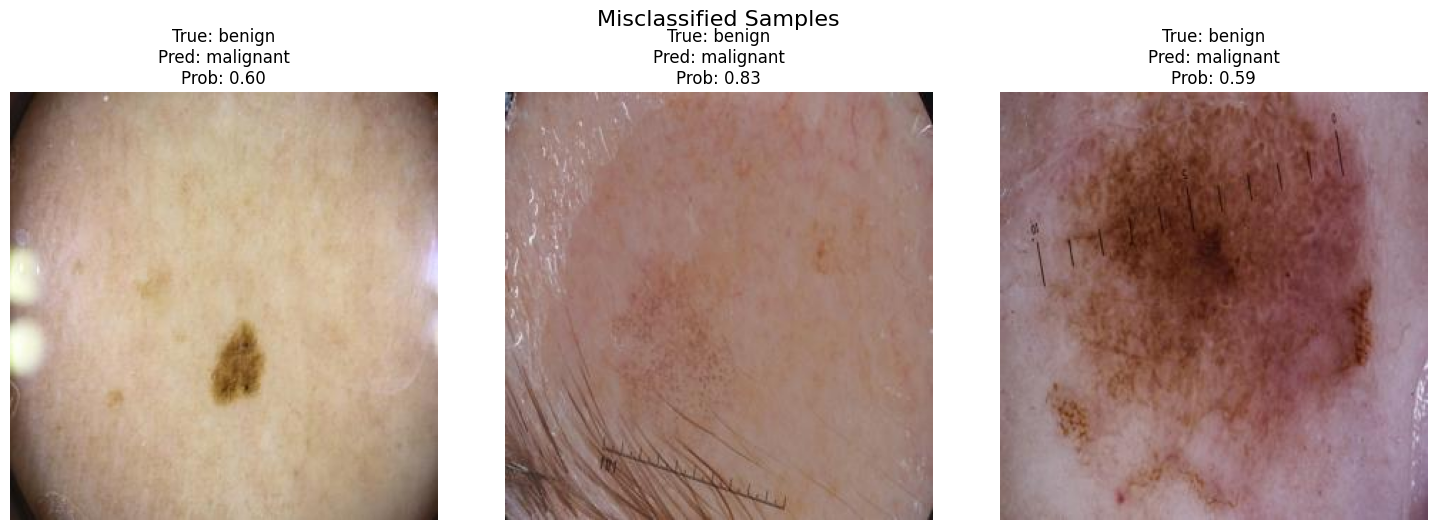

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# Class Mapping
print("Class Indices:", test_generator.class_indices)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

# Train
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
with tf.device(device):
    history = model.fit(
        train_generator,
        validation_data=test_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights
    )

# Evaluate
loss, acc = model.evaluate(test_generator)
print(f"Final Validation Accuracy: {acc * 100:.2f}%")

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1).flatten()
y_pred = (y_pred_probs > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



# Filepaths and class labels
filepaths = test_generator.filepaths
class_labels = list(test_generator.class_indices.keys())

# Misclassified indices
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total Misclassified Samples: {len(misclassified_indices)}")

# Display up to 3 misclassified images
num_to_display = min(3, len(misclassified_indices))

plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:num_to_display]):
    img = plt.imread(filepaths[idx])
    true_class = class_labels[y_true[idx]]
    predicted_class = class_labels[y_pred[idx]]
    confidence = y_pred_probs[idx]

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {predicted_class}\nProb: {confidence:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.suptitle("Misclassified Samples", fontsize=16, y=1.05)
plt.show()
